In [1]:
import numpy as np
import scipy
from qutip import *
from numba import jit, njit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import plot
import plotly.graph_objs as go

In [397]:
sx = sigmax()/2
sy = sigmay()/2
sz = sigmaz()/2

s = sx - 1j*sy 

s_ = [ tensor(s, qeye(2), qeye(2)), tensor( qeye(2), s, qeye(2)),tensor( qeye(2), qeye(2), s) ]
sz_ = [ tensor(sz, qeye(2), qeye(2)), tensor( qeye(2), sz, qeye(2)),tensor( qeye(2), qeye(2), sz) ]

SZ = sz_[0]+sz_[1]+sz_[2]
evalsZ, evecsZ = SZ.eigenstates(sort='low')
Vacuum = evecsZ[0]
Upstate = evecsZ[7]

om0 = 2*np.pi * 0   # in GHz
om1 = 2*np.pi * 0
om2 = 2*np.pi * 0
J = 2*np.pi * 0.

gamma = 2*np.pi * 0.001
gamma_coll = 2*np.pi * 1.
pump = 2*np.pi * .1
deph = 2*np.pi * 0.


H = om0*sz_[0] + om1*sz_[1] + om2*sz_[2]
for n in range(3):
    for m in range(3):
        H += -J/2*( s_[n].dag()*s_[m] )
        
        
jump2 = s_[0]+s_[1]+s_[2]

arr_jump_tot = [ np.sqrt(gamma_coll)*jump2 ]
for n in range(3):
    arr_jump_tot.append( np.sqrt(gamma)*s_[n] )
    arr_jump_tot.append( np.sqrt(pump)*s_[n].dag() )
    arr_jump_tot.append( np.sqrt(deph)*s_[n].dag()*s_[n] )

Ltot = liouvillian(H, arr_jump_tot)
rho_ss = steadystate(Ltot)


Ntau = 1000
tau_f = 10      # in ns
taus = np.linspace(0., tau_f, Ntau)

Nop1 = s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2]
Cop1 = s_[0].dag()*(s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2])*s_[0] + s_[1].dag()*(s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2])*s_[1] + s_[2].dag()*(s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2])*s_[2]

N1 = expect( Nop1, rho_ss )
N2 = expect( jump2.dag()*jump2, rho_ss )

#Nw = 100000
#taulist = np.linspace(0, 16., Nw)
#G1 = correlation_2op_1t(H, rho_ss, taulist, arr_jump_tot, cj_S.dag(), cj_S, solver='me')
#wlist, S1 = spectrum_correlation_fft(taulist, G1)

G3 = correlation_3op_1t( H, rho_ss, taus, arr_jump_tot,    jump2.dag(), Cop1, jump2 )
g3 = G3/(N1**2*N2)

#G2 = correlation_3op_1t( H, rho_ss, taus, arr_jump_tot,    jump2.dag(),  jump2.dag()*jump2, jump2 )
#g2 = G2/(N2**2)
G2 = correlation_3op_1t( H, rho_ss, taus, arr_jump_tot,    s_[0].dag(),  s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2], s_[0] )
G2 += correlation_3op_1t( H, rho_ss, taus, arr_jump_tot,    s_[1].dag(),  s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2], s_[1] )
G2 += correlation_3op_1t( H, rho_ss, taus, arr_jump_tot,    s_[2].dag(),  s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2], s_[2] )
g2 = G2/( expect( s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2], rho_ss) )**2

#G2 = correlation_3op_1t( H, rho_ss, taus, arr_jump_tot,    s_[0].dag(),  s_[0].dag()*s_[0], s_[0] )
#g2 = G2/( expect( s_[0].dag()*s_[0], rho_ss) )**2



antiWstate = jump2*Upstate
antiWstate = antiWstate/np.sqrt(antiWstate.overlap(antiWstate))
rho_aW = antiWstate*antiWstate.dag()
#G2aW = correlation_3op_1t( H, rho_aW, taus, arr_jump_tot,    jump2.dag(),  jump2.dag()*jump2, jump2 )
#NaW = expect( jump2.dag()*jump2, rho_aW)
#g2aW = G2aW/(NaW**2)
G2aW = correlation_3op_1t( H, rho_aW, taus, arr_jump_tot,    s_[0].dag(),  s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2], s_[0] )
G2aW += correlation_3op_1t( H, rho_aW, taus, arr_jump_tot,    s_[1].dag(),  s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2], s_[1] )
G2aW += correlation_3op_1t( H, rho_aW, taus, arr_jump_tot,    s_[2].dag(),  s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2], s_[2] )
g2aW = G2aW/( expect( s_[0].dag()*s_[0] + s_[1].dag()*s_[1] + s_[2].dag()*s_[2], rho_aW) )**2



In [398]:
Wstate = jump2.dag()*Vacuum
Wstate = Wstate/np.sqrt(Wstate.overlap(Wstate))
antiWstate = jump2*Upstate
antiWstate = antiWstate/np.sqrt(antiWstate.overlap(antiWstate))
print(Upstate)

rho_jumped = jump2*rho_ss*jump2.dag()
rho_jumped = rho_jumped/rho_jumped.tr()
Fjumped_W = expect( rho_jumped,  Wstate)
Fjumped_aW = expect( rho_jumped,  antiWstate)
F_W = expect( rho_ss,  Wstate)
F_aW = expect( rho_ss,  antiWstate)

print( Fjumped_W, Fjumped_aW, F_W,  F_aW  )

Quantum object: dims=[[2, 2, 2], [1, 1, 1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
0.17712827646006604 0.0566588710054455 0.016504746106335292 0.009010422953009915


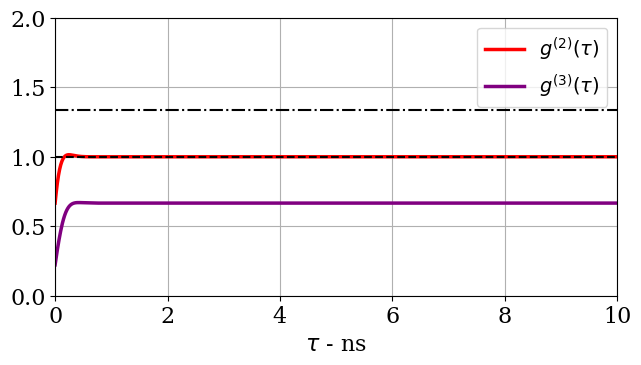

In [396]:
# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}

# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

color_str = ['purple', 'red']

plt.plot(taus, g2.real, color='%s' % (color_str[1]), linewidth=2.5, label=r'$g^{(2)}(\tau)$')
#plt.plot(taus, g2aW.real, color='green', linewidth=2.5, label=r'$g^{(2)}(\tau)$')
plt.plot(taus, g3.real, color='%s' % (color_str[0]), linewidth=2.5, label=r'$g^{(3)}(\tau)$')
plt.plot(taus, 4/3*np.ones(len(taus)), color='black', linestyle='-.', linewidth=1.5)
plt.plot(taus, 1*np.ones(len(taus)), color='black', linestyle='--', linewidth=1.5)


plt.ylim((0,2))
#plt.xlim((0,20*t0))
plt.xlim((0,tau_f))


#plt.xlabel(r'$\tau$ - ns', fontdict=font)
plt.xlabel(r'$\tau$ - ns', fontdict=font)
#plt.ylabel(r'$g^{(3)}(\tau)$', fontdict=font)

plt.gcf().set_size_inches(170 / 25.4, 100 / 25.4)
plt.tight_layout()

#plt.legend( fontsize=12)

plt.legend(loc='best', fontsize=14)
plt.grid()

#plt.savefig('filered_g2_v3.pdf' )

